# HOG with face and natural pictures

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import cv2
import dlib
from time import time
import matplotlib.pyplot as plt
import copy
import warnings
from tqdm.notebook import tqdm
from sklearn import metrics
from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')

In [3]:
#dataset
#df = pd.read_pickle("/Users/laurabraadrasmussen/Bachelorprojekt/in_the_wild_df3.pkl")
df = pd.read_pickle("/Users/laurabraadrasmussen/Bachelorprojekt/df_w_natural.pkl")

<AxesSubplot:xlabel='Ages', ylabel='Density'>

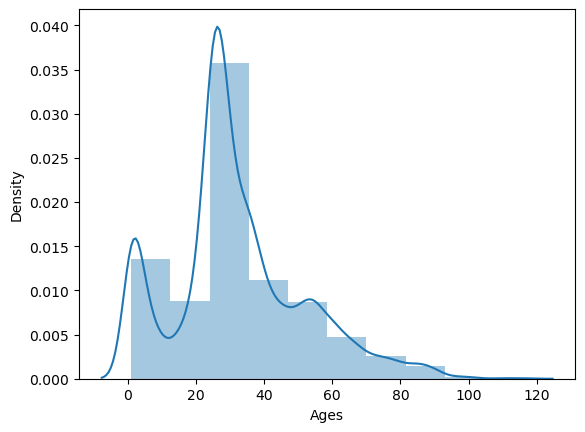

In [4]:
sns.distplot(df['Ages'],kde=True, bins=10)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20257 entries, 0 to 20256
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Images                   20257 non-null  object 
 1   Ages                     14344 non-null  float64
 2   Genders                  14344 non-null  float64
 3   Race                     14344 non-null  float64
 4   Caucasien/Non-caucasian  14344 non-null  float64
 5   Label                    20257 non-null  int64  
 6   Folder                   20257 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.1+ MB
None


## HOG

In [6]:
# Get the HoG face detection model.
hog_face_detector = dlib.get_frontal_face_detector()
hog_face_detector

In [7]:
def hogDetectFaces(image, hog_face_detector, display = True):
    '''
    This function performs face(s) detection on an image using dlib hog face detector.
    Args:
        image:             The input image of the person(s) whose face needs to be detected.
        hog_face_detector: The hog face detection model required to perform the detection on the input image.
        display:           A boolean value that is if set to true the function displays the original input image, 
                           and the output image with the bounding boxes drawn and time taken written and returns nothing.
    Returns:
        output_image: A copy of input image with the bounding boxes drawn.
        results:      The output of the face detection process on the input image.
    '''
    
    # Get the height and width of the input image.
    
    height, width, _ = image.shape
    
    
    # Create a copy of the input image to draw bounding boxes on.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #imgRGB = image
    # Get the current time before performing face detection.
    start = time()

    # Perform the face detection on the image.
    results = hog_face_detector(imgRGB, 0)
    
    
    # Get the current time after performing face detection.
    end = time()
    
    # Loop through the bounding boxes of each face detected in the image.
    for bbox in results:
        
        # Retrieve the left most x-coordinate of the bounding box.
        x1 = bbox.left()
        
        # Retrieve the top most y-coordinate of the bounding box.
        y1 = bbox.top()
        
        # Retrieve the right most x-coordinate of the bounding box.
        x2 = bbox.right()
        
        # Retrieve the bottom most y-coordinate of the bounding box.       
        y2 = bbox.bottom()

        # Draw a rectangle around a face on the copy of the image using the retrieved coordinates.
        cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=width//200)
    
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Write the time take by face detection process on the output image. 
        cv2.putText(output_image, text='Time taken: '+str(round(end - start, 2))+' Seconds.', org=(2, 30),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=width//700, color=(0,0,255), thickness=width//500)
        
        # Display the original input image and the output image.
        plt.figure(figsize=[5,5])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image and results of face detection.
        return cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR), results

In [8]:
def process_images(df, hog_face_detector, batch_size=100):
    total_images = len(df)
    num_batches = (total_images + batch_size - 1) // batch_size

    all_results = []

    for batch in tqdm(range(num_batches)):
        start_index = batch * batch_size
        end_index = min((batch + 1) * batch_size, total_images)

        images_output = []
        for i in range(start_index, end_index):
            image = np.array(df['Images'][i])
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            images_output.append(image)

        hog_results = []
        for image in images_output:
            hog_results.append(hogDetectFaces(image, hog_face_detector, display = False))

        all_results.extend(hog_results)

    return all_results

In [9]:
all_results = process_images(df, hog_face_detector, batch_size=100)

  0%|          | 0/203 [00:00<?, ?it/s]

In [11]:
df['Predicted'] = 3

In [12]:
Predicted = [] #[0 if len(hogfaces[i][1]) == 0 else 1 for i in range(len(hogfaces))]

for i in range(len(all_results)):
    if len(all_results[i][1]) == 0:
        df['Predicted'].iloc[i] = 0
    else:
        df['Predicted'].iloc[i]  = 1

## Confusion matrix

In [13]:
Actual = df['Label']
Predicted = df['Predicted']

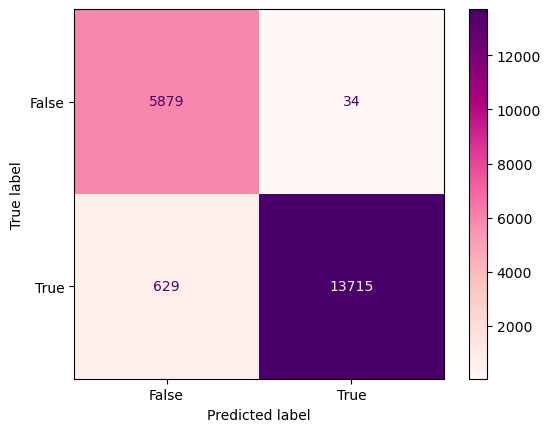

In [14]:
Confusion_matrix = metrics.confusion_matrix(Actual, Predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = Confusion_matrix, display_labels = [False, True] )
cm_display.plot(cmap = 'RdPu')
plt.show()

In [15]:
#investigation of false positives
#df[(df['Label'] == 0 ) & (df['Predicted']==1)]

## Evaluation

In [16]:
Accuracy  = metrics.accuracy_score(Actual, Predicted)
Accuracy

0.9672705731352125

In [17]:
Precision = metrics.precision_score(Actual, Predicted) # true positive rate 
Precision

0.9975270928794822

In [18]:
Sensitivity = metrics.recall_score(Actual, Predicted)
Sensitivity

0.956148912437256

In [19]:
Specificity = metrics.recall_score(Actual, Predicted, pos_label = 0)
Specificity

0.9942499577202774

In [20]:
F_score = metrics.f1_score(Actual, Predicted)
F_score

0.9763998149005091

## Dataframe of the not detected faces

In [23]:
not_dect_index = [i for i in range(len(all_results)) if (len(all_results[i][1]) == 0)&( df['Folder'][i] == 'Person')] #without the natural pic
not_dect_images = [df['Images'][i] for i in not_dect_index]
not_dect_ages = [df['Ages'][i] for i in not_dect_index]
not_dect_genders = [df['Genders'][i] for i in not_dect_index]
not_dect_races = [df['Race'][i] for i in not_dect_index]
not_dect_caucasian = [df['Caucasien/Non-caucasian'][i] for i in not_dect_index]


df_not_detected = pd.DataFrame({
    'not_dect_index': not_dect_index,
    'not_dect_images': not_dect_images,
    'not_dect_ages': not_dect_ages,
    'not_dect_genders': not_dect_genders,
    'not_dect_races': not_dect_races,
    'not_dect_caucasian': not_dect_caucasian
})

## Chi 2 testing

In [24]:
# Create a contingency table
df_person = df[df['Folder']=='Person']
unique_race, counts = np.unique(df_person['Race'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))

detected = []   # Frequencies of detected faces in each group
not_detected = []   # Frequencies of not detected faces in each group
for i in unique_race:
    detected.append(counts_dict[i]- len(df_not_detected[df_not_detected["not_dect_races"] == i]))
    not_detected.append(len(df_not_detected[df_not_detected["not_dect_races"] == i]))

# Perform the chi-square test
observed = [detected, not_detected]
chi2, p, dof, expected = chi2_contingency(observed)

# chi2: The chi-square test statistic
# p: The p-value
# dof: Degrees of freedom
# expected: The expected frequencies under the null hypothesis

# Print the results
print("Chi-square test statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square test statistic: 404.3030555592585
p-value: 2.5886347309533775e-87
Degrees of freedom: 3
Expected frequencies: [[3428.75 3428.75 3428.75 3428.75]
 [ 157.25  157.25  157.25  157.25]]


In [25]:
detected, not_detected

([3501, 3542, 3223, 3449], [85, 44, 363, 137])

## True positives

In [26]:
df_person = df[df['Folder']=='Person']
unique_race, counts = np.unique(df_person['Race'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))

percentage_r = [((counts_dict[i]-(len(df_not_detected[df_not_detected["not_dect_races"] == i]))) / counts_dict[i])for i in unique_race]
percentage_r

[0.9762967094255438,
 0.9877300613496932,
 0.8987730061349694,
 0.9617958728388176]

In [27]:
#test against threshold 80%
min(percentage_r)/max(percentage_r)
#0.9036/0.9704 

0.9099378881987579

In [ ]:
0.9036/0.9904

## Distribution in not detected faces

In [28]:
unique_race, counts = np.unique(df_not_detected['not_dect_races'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))
dist = counts/sum(counts)*100

In [29]:
dist

array([13.51351351,  6.99523052, 57.71065183, 21.78060413])

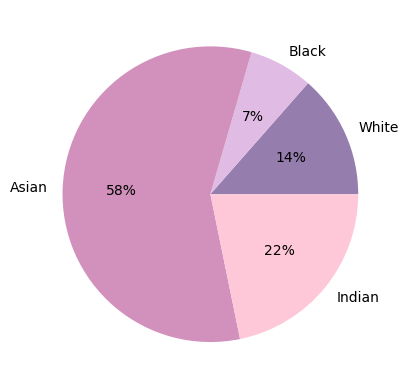

In [30]:
labels = ['White','Black','Asian','Indian']
colors = ['#957DAD','#E0BBE4','#D291BC','#FEC8D8']
plt.pie(dist, labels = labels, colors = colors, autopct = '%1.f%%')
plt.show()

## Bar plots
## Race

In [31]:
unique_race, counts = np.unique(df_person['Race'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))

percentage_r = [(len(df_not_detected[df_not_detected["not_dect_races"] == i]) / counts_dict[i]) * 100 for i in unique_race]

In [32]:
percentage_r

[2.3703290574456215,
 1.2269938650306749,
 10.122699386503067,
 3.8204127161182377]

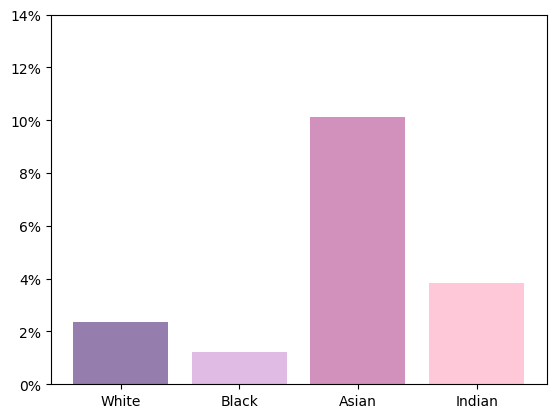

In [33]:
labels = ['White','Black','Asian','Indian']
colors = ['#957DAD','#E0BBE4','#D291BC','#FEC8D8']
plt.bar(list(unique_race), percentage_r, color = colors)
plt.xticks(list(unique_race), labels)
plt.ylim([0, 14])
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show()

### Køn

In [34]:
unique_gender, counts = np.unique(df_person['Genders'], return_counts=True)
counts_dict = dict(zip(unique_gender, counts))

percentage_g = [(len(df_not_detected[df_not_detected["not_dect_genders"] == i]) / counts_dict[i]) * 100 for i in unique_gender]

In [35]:
percentage_g

[3.93228472407358, 4.881613563285589]

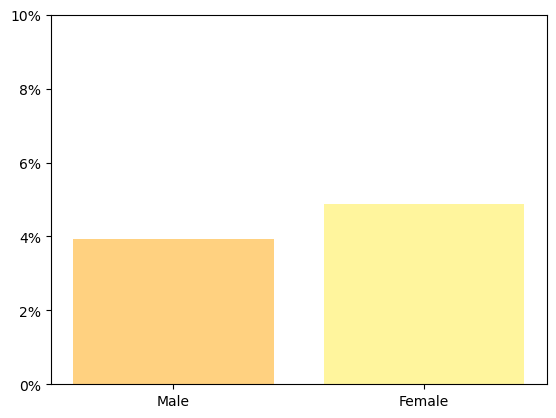

In [36]:
colors = ['#FFD180','#FFF59D']
plt.bar(list(unique_gender), percentage_g, color = colors)
plt.xticks(list(unique_gender), ['Male', 'Female'])
plt.ylim([0, 10])
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show()

### Caucasian

In [37]:
unique_caucasian, counts = np.unique(df_person['Caucasien/Non-caucasian'], return_counts=True)
counts_dict = dict(zip(unique_caucasian, counts))
percentage_c = [(len(df_not_detected[df_not_detected["not_dect_caucasian"] == i]) / counts_dict[i]) * 100 for i in unique_caucasian]

In [38]:
percentage_c

[2.3703290574456215, 5.056701989217326]

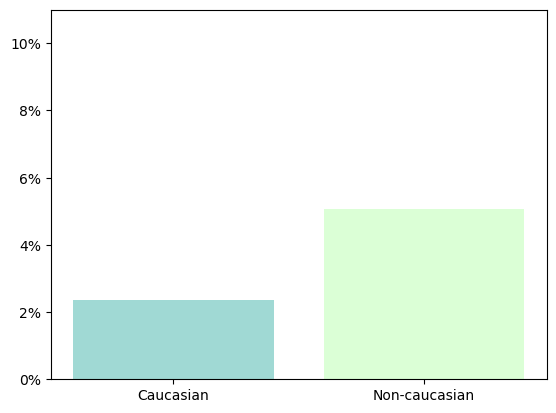

In [39]:
colors = ['#A0D9D4', '#DBFFD6']
labels = ['Caucasian', 'Non-caucasian']
plt.bar(list(unique_caucasian), percentage_c,  color = colors)
plt.xticks(list(unique_caucasian), labels)
plt.ylim([0, 11])
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show()

### Alder

In [40]:
unique_ages, counts = np.unique(df_person['Ages'], return_counts=True)
counts_dict = dict(zip(unique_ages, counts))
percentage_a = [(len(df_not_detected[df_not_detected["not_dect_ages"] == i]) / counts_dict[i]) * 100 for i in unique_ages]



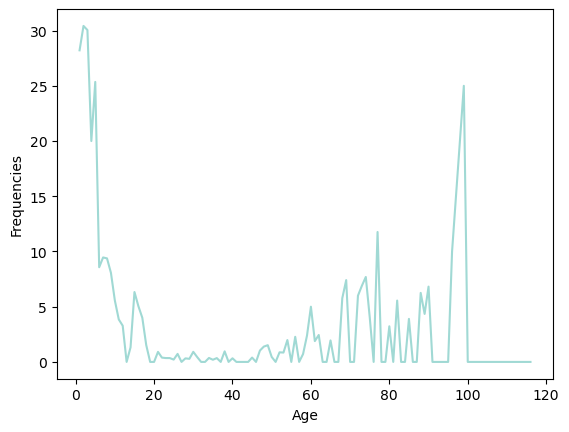

In [41]:
plt.plot(list(unique_ages), percentage_a, color = '#A0D9D4')
plt.xlabel('Age')
plt.ylabel('Frequencies')

plt.show()

# Displaying False negatives

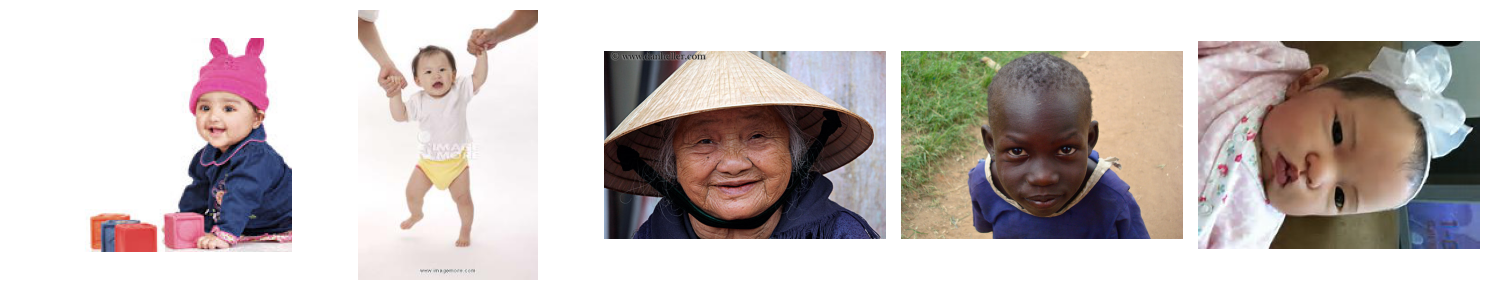

In [42]:
import random
random_indices = random.sample(range(len(df_not_detected)), 5)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, index in enumerate(random_indices):
    image_path = df_not_detected['not_dect_images'][index]
    
    axs[i].imshow(image_path)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

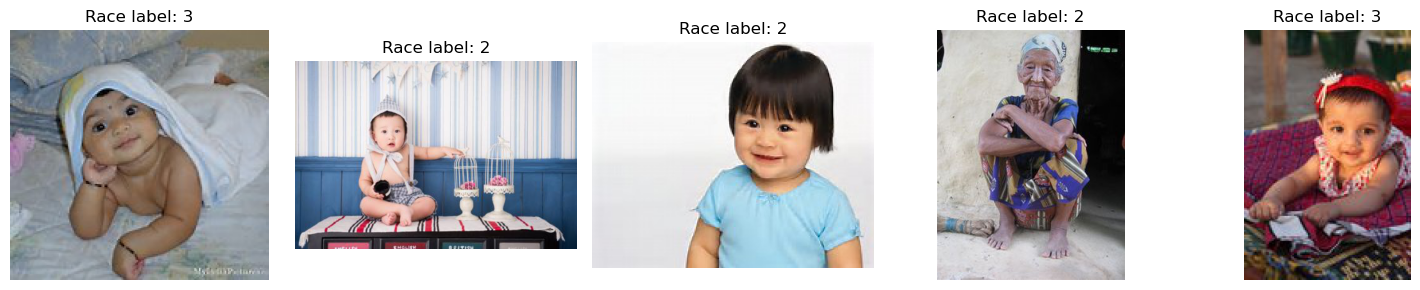

In [43]:
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(df_not_detected)), 5)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, index in enumerate(random_indices):
    image_path = df_not_detected['not_dect_images'][index]
    #image = plt.imread(image_path)
    axs[i].imshow(image_path)
    axs[i].axis('off')
    axs[i].set_title('Race label: ' + str(int(df_not_detected['not_dect_races'][index])))

plt.tight_layout()
plt.show()

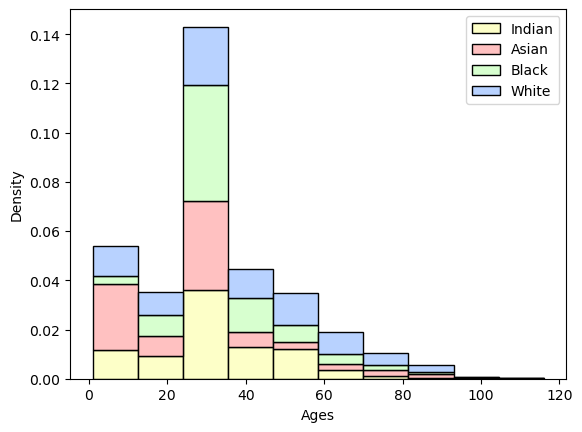

In [44]:
colors = ['#A0C4FF','#CAFFBF','#FFADAD','#FDFFB6']
labels = ['Indian','Asian','Black','White']

sns.histplot(data = df, x = df['Ages'], hue = df['Race'], bins=10, palette =colors, common_norm = False, stat='density', multiple = 'stack')
plt.legend(labels)
plt.xlabel('Ages')
plt.show()

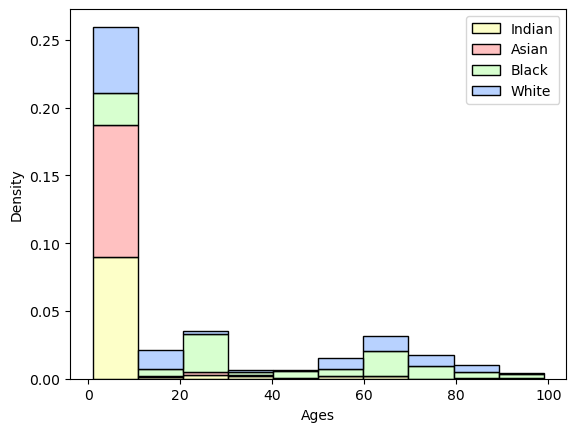

In [45]:
colors = ['#A0C4FF','#CAFFBF','#FFADAD','#FDFFB6']
labels = ['Indian','Asian','Black','White']

sns.histplot(data = df_not_detected, x = df_not_detected['not_dect_ages'], hue = df_not_detected['not_dect_races'], bins=10, palette = colors, common_norm = False, stat='density', multiple = 'stack')
plt.legend(labels)
plt.xlabel('Ages')
plt.show()